# Fed vs. fasted: comparing RSNs in giant Mappers

Let's recreate Figure 4 in Poldrack et al. 2015, Nature Communications, using Mapper!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *

In [3]:
%matplotlib inline

## Load data

In [30]:
sessions = load_scrubbed(n_sessions=10,  merge=True,#False,
    apply_tmask=True,
    apply_rmask=True, rmask_kwds=dict(n=5, minor=False),
    zscore=False
    )

INFO:load_data:load_scrubbed(**{'n_sessions': 10, 'merge': True, 'apply_tmask': True, 'apply_rmask': True, 'rmask_kwds': {'n': 5, 'minor': False}, 'zscore': False})
INFO:load_data:Loading data...
INFO:root:  [+] session: 0, file: sub014.txt
INFO:root:      keeping: 505 (time points)
INFO:root:      keeping: 437 (regions)
INFO:root:  [+] session: 1, file: sub015.txt
INFO:root:      keeping: 508 (time points)
INFO:root:      keeping: 437 (regions)
INFO:root:  [+] session: 2, file: sub016.txt
INFO:root:      keeping: 508 (time points)
INFO:root:      keeping: 437 (regions)
INFO:root:  [+] session: 3, file: sub017.txt
INFO:root:      keeping: 504 (time points)
INFO:root:      keeping: 437 (regions)
INFO:root:  [+] session: 4, file: sub018.txt
INFO:root:      keeping: 508 (time points)
INFO:root:      keeping: 437 (regions)
INFO:root:  [+] session: 5, file: sub019.txt
INFO:root:      keeping: 513 (time points)
INFO:root:      keeping: 437 (regions)
INFO:root:  [+] session: 6, file: sub020.t

### Clean data

Load temporal masks and remove TRs with excessive motion. Additionally, remove parcels that do not belong to major RSNs.

In [31]:
splits = get_data_splits(sessions, zscore=True, groupby='day_of_week', groups={2:'fast', 4:'fed'}, threshold=0.5, density=None)

print('splits: ', splits.keys())

            1.0 => day_of_week_0    x.shape: (1517, 437)  RSN.shape: (1517, 5)
            2.0 => fast             x.shape: (1532, 437)  RSN.shape: (1532, 5)
            4.0 => fed              x.shape: (1856, 437)  RSN.shape: (1856, 5)
splits:  dict_keys(['day_of_week_0', 'fast', 'fed'])


## Generate $MAPPER$ graphs

In [32]:
results = Bunch()

### Start local server for visualization

In [33]:
%%bash --bg

python3 -m http.server 8800

Starting job # 3 in a separate thread.


### Run Mapper in temporal space - create one super graph for both fed and fasted

In [35]:
def get_cover(reso=20, gain=0.8, n_components=2):
    bounds = [[-(gain/reso), 1+(gain/reso)] for _ in range(n_components)]
    print('reso={}  gain={}  limits={}'.format(reso, gain, bounds))
    return km.Cover(reso, gain, limits=bounds)

# init cover, cluster
projection = PCA(n_components=2)
cover = get_cover(20, 0.67, n_components=projection.n_components)
clusterer = HDBSCAN(min_cluster_size=5, allow_single_cluster=True)

# for visualization
path_html_fmt = 'results/{}_n10_rsn5_pca2_scan5_r20_g0.67.html'

reso=20  gain=0.67  limits=[[-0.0335, 1.0335], [-0.0335, 1.0335]]


#### (split = fed)

In [36]:
# Run Mapper/DyNeuSR
print('Running mapper on fed data...')
try:
    splits.fed.lens = results.fed.get('lens')
    print('*** Found lens... (set lens=None to re-run)')
except:
    splits.fed.lens = None
results.fed = run_mapper(
    splits.fed.X, splits.fed.RSN, lens=splits.fed.lens, verbose=1, 
    projection=projection, cover=cover, clusterer=clusterer,
    )

Running mapper on fed data...
KeplerMapper()
Mapping on data shaped (1856, 437) using lens shaped (1856, 2)

Creating 400 hypercubes.

Created 331 edges and 166 nodes in 0:00:00.548552.


label,group,value,row_count
Cingulo_opercular,0,367,1855
Frontoparietal_1,1,341,1855
Somatomotor,2,279,1855
Visual_2,3,360,1855
DMN,4,347,1855


In [37]:
# Visualize DyNeuGraph
results.fed.dG.visualize(path_html=path_html_fmt.format('fed_super'), show=True, PORT=8800)

[Force Graph] http://localhost:8800/results/fed_super_n10_rsn5_pca2_scan5_r20_g0.67.html


DyNeuGraph()

<Figure size 432x288 with 0 Axes>

##### Quick look (png)

![fed_super](results/png/fed_super_n10_rsn5_pca2_scan5_r20_g0.67.png)


#### (split = fasted)

In [38]:
# Run Mapper/DyNeuSR
print('Running mapper on fasted data...')
try:
    splits.fast.lens = results.fast.get('lens')
    print('*** Found lens... (set lens=None to re-run)')
except:
    splits.fast.lens = None
results.fast = run_mapper(
    splits.fast.X, splits.fast.RSN, lens=splits.fast.lens, verbose=1, 
    projection=projection, cover=cover, clusterer=clusterer,
    )

Running mapper on fasted data...
KeplerMapper()
Mapping on data shaped (1532, 437) using lens shaped (1532, 2)

Creating 400 hypercubes.

Created 300 edges and 145 nodes in 0:00:00.609426.


label,group,value,row_count
Cingulo_opercular,0,271,1531
Frontoparietal_1,1,249,1531
Somatomotor,2,265,1531
Visual_2,3,256,1531
DMN,4,298,1531


In [39]:
# Visualize DyNeuGraph
results.fast.dG.visualize(path_html=path_html_fmt.format('fast_super'), show=True, PORT=8800)

[Force Graph] http://localhost:8800/results/fast_super_n10_rsn5_pca2_scan5_r20_g0.67.html


DyNeuGraph()

<Figure size 432x288 with 0 Axes>

##### Quick look (png)


![fast_super](results/png/fast_super_n10_rsn5_pca2_scan5_r20_g0.67.png)


### Check TCMs

In [40]:
import bct 

def visualize_metric(W=None, c=None, metric=bct.module_degree_zscore, cmap='plasma'):
    """ Evaluate metric and plot scores
    
    
    """
    print('[visualize_metric] metric: ', metric)
    metric_func = metric if callable(metric) else getattr(bct, metric)
    
    # copy other inputs
    coloring_ = c.copy()

    # loop through columns in c
    scores_ = dict()
    for column in coloring_.columns:
        ci = coloring_[column].values
        try:
            ci = ci.astype(float)
        except Exception as e:
            continue
        print('                   scoring:', column, ci.shape, end="")
        
        # evaluate
        zi = metric_func(W, ci)
        
        # reshape
        print(" score.shape:", np.shape(zi), end="")
        if np.shape(zi)[0] <= 2:
            zi = zi[0]
            
        zi = zi.reshape(zi.shape[0], -1)
        print(" =>", np.shape(zi))

        # save
        scores_[column] = Bunch(ci=ci.copy(), zi=zi.copy())

        # plot
        fig, axes = plt.subplots(1, 5, figsize=(24, 8))            

        # TCM
        sns.heatmap(W, ax=axes[0],   square=True, cbar=False, xticklabels=500, yticklabels=500, cmap=cmap)      
        axes[0].set_title("TCM", fontweight='bold')

        # TCM + ci
        sns.heatmap(np.zeros_like(W) + ci.reshape(-1, 1), xticklabels=False,yticklabels=500,  square=True, cbar=False, cmap=cmap, ax=axes[1])    
        sns.heatmap(W*ci + (W*ci).T, square=True,  cbar=False, xticklabels=500, yticklabels=500, cmap=cmap, ax=axes[2])    
        axes[1].set_title("communities ({})".format(column), fontweight='bold')

        # TCM + zi
        sns.heatmap(np.zeros_like(W) + zi.reshape(-1, 1), xticklabels=False, yticklabels=500,  square=True, cbar=False,  cmap=cmap, ax=axes[3])     
        sns.heatmap(W*zi + (W*zi).T, square=True, cbar=False, xticklabels=500, yticklabels=500, cmap=cmap, ax=axes[4])    
        axes[3].set_title("score", fontweight='bold')

        # show
        plt.show()

    return scores_


### Evaluate graph metrics

In [41]:
scores = splits.scores = Bunch()

result = results.fed
split = splits.fed

#### Metrics (RSN)

In [42]:
# TCM, community assignments
TCM = result.TCM.copy()
coloring = split.RSN.copy()

# defined data, cols
columns = [i for i,_ in enumerate(coloring.columns)][:5]
data_id = np.arange(TCM.shape[0]).astype(int)

# for debugging
#data_id = data_id[:500]
coloring = coloring.iloc[data_id, columns]
TCM = TCM[data_id, :][:, data_id]

print(data_id.shape)
print(coloring.shape)
print(TCM.shape)

# for results
scores.RSN = Bunch()

(1856,)
(1856, 5)
(1856, 1856)


[visualize_metric] metric:  <function module_degree_zscore at 0x118fa9048>
                   scoring: Cingulo_opercular (1856,) score.shape: (1856,) => (1856, 1)


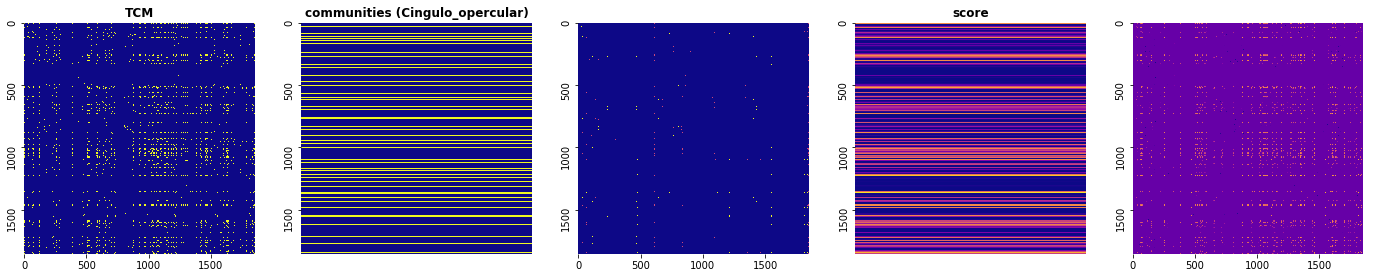

                   scoring: Frontoparietal_1 (1856,) score.shape: (1856,) => (1856, 1)


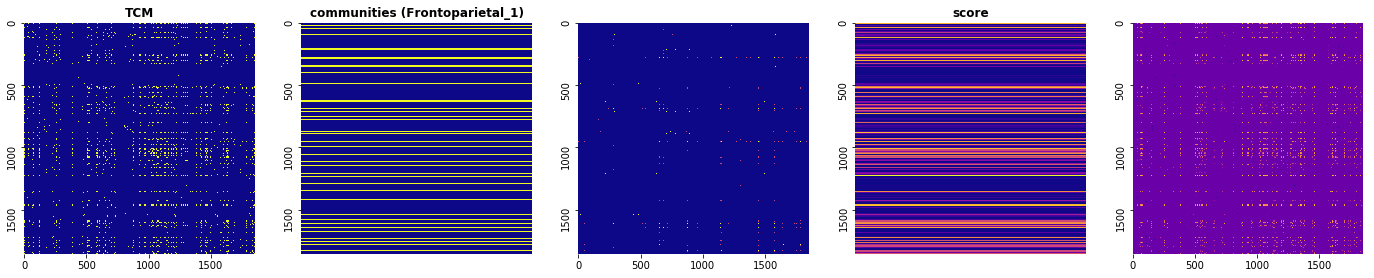

                   scoring: Somatomotor (1856,) score.shape: (1856,) => (1856, 1)


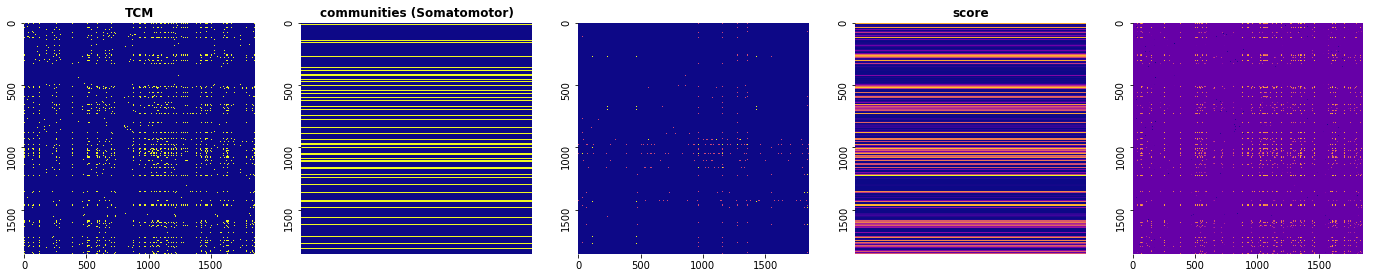

                   scoring: Visual_2 (1856,) score.shape: (1856,) => (1856, 1)


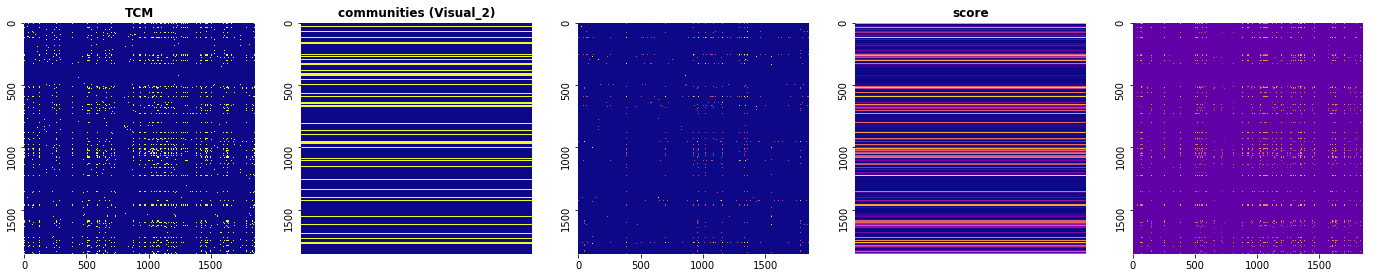

                   scoring: DMN (1856,) score.shape: (1856,) => (1856, 1)


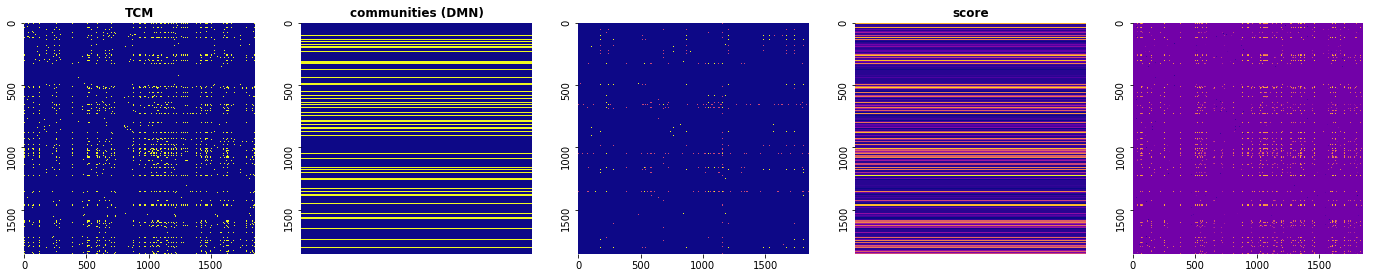

In [43]:
scores.RSN.modz = visualize_metric(W=TCM, c=coloring, metric=bct.module_degree_zscore)

In [44]:
#scores.RSN.pcoef = visualize_metric(W=TCM, c=coloring, metric=bct.participation_coef)

In [45]:
#scores.RSN.pcoef_s = visualize_metric(W=TCM, c=coloring, metric=bct.participation_coef_sign)

#### Metrics (meta)

In [46]:
# TCM, community assignments
TCM = result.TCM.copy()
coloring = split.meta.copy()

# defined data, cols
columns = [i for i,_ in enumerate(coloring.columns) if _ in ('session_id', 'tr_id')]
data_id = np.arange(TCM.shape[0]).astype(int)

# for debugging
#data_id = data_id[:500]
coloring = coloring.iloc[data_id, columns]
TCM = TCM[data_id, :][:, data_id]

print(data_id.shape)
print(coloring.shape)
print(TCM.shape)

# for results
scores.meta = Bunch()

(1856,)
(1856, 2)
(1856, 1856)


[visualize_metric] metric:  <function module_degree_zscore at 0x118fa9048>
                   scoring: session_id (1856,) score.shape: (1856,) => (1856, 1)


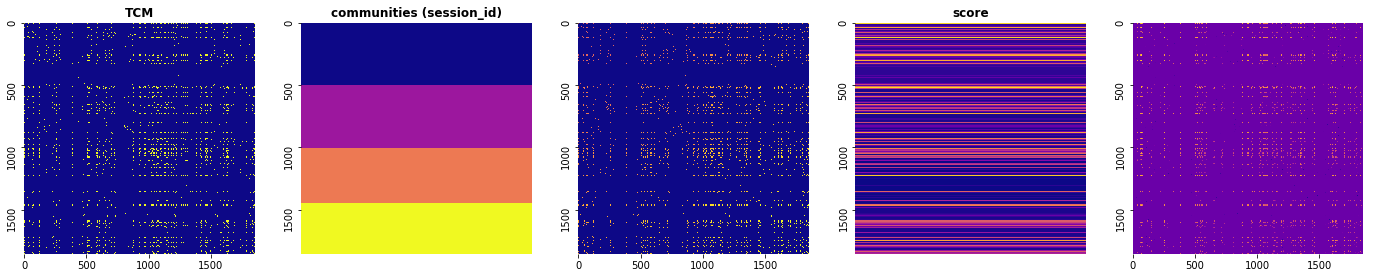

                   scoring: tr_id (1856,) score.shape: (1856,) => (1856, 1)


/Users/calebgeniesse/src/miniconda3/lib/python3.6/site-packages/bct/algorithms/centrality.py:642: RuntimeWarning: invalid value encountered in true_divide
  Z[np.where(ci == i)] = (Koi - np.mean(Koi)) / np.std(Koi)


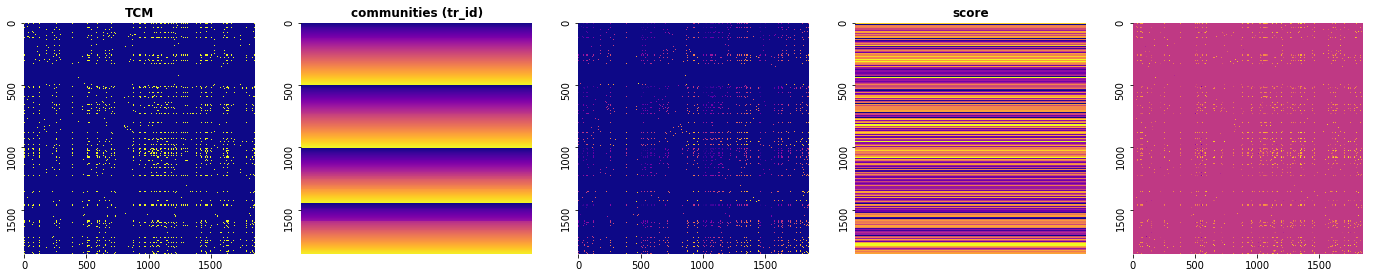

In [47]:
scores.meta.modz = visualize_metric(W=TCM, c=coloring, metric=bct.module_degree_zscore)

In [48]:
#scores.meta.pcoef = visualize_metric(W=TCM, c=coloring, metric=bct.participation_coef)

In [49]:
#scores.meta.pcoef_s = visualize_metric(W=TCM, c=coloring, metric=bct.participation_coef_sign)

#### Metrics (`panas:`)

In [50]:
# TCM, community assignments
TCM = result.TCM.copy()
coloring = split.meta.copy()

# defined data, cols
columns = [i for i,_ in enumerate(coloring.columns) if 'panas:' in _]
data_id = np.arange(TCM.shape[0]).astype(int)

# for debugging
#data_id = data_id[:500]
coloring = coloring.iloc[data_id, columns]
TCM = TCM[data_id, :][:, data_id]

print(data_id.shape)
print(coloring.shape)
print(TCM.shape)

# for results
scores.meta.panas = Bunch()

(1856,)
(1856, 63)
(1856, 1856)


[visualize_metric] metric:  <function module_degree_zscore at 0x118fa9048>
                   scoring: panas:active (1856,) score.shape: (1856,) => (1856, 1)


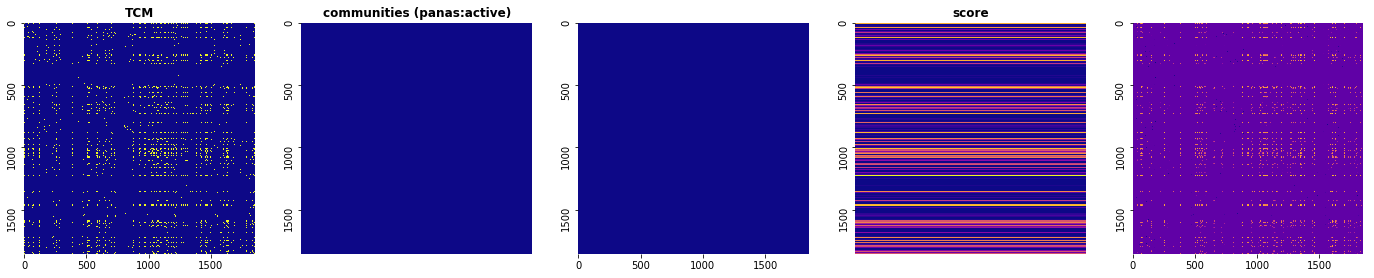

                   scoring: panas:afraid (1856,) score.shape: (1856,) => (1856, 1)


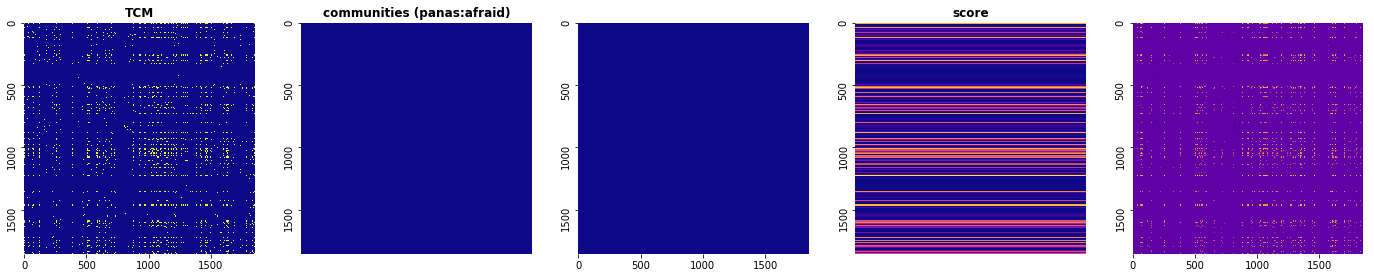

                   scoring: panas:alert (1856,) score.shape: (1856,) => (1856, 1)


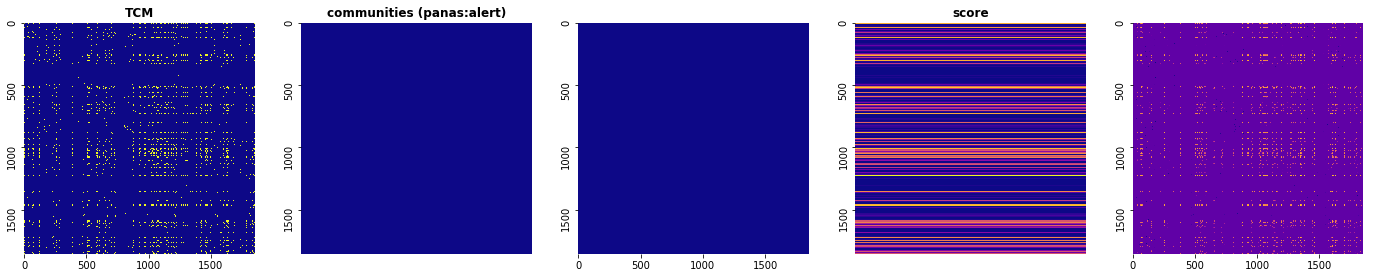

                   scoring: panas:alone (1856,) score.shape: (1856,) => (1856, 1)


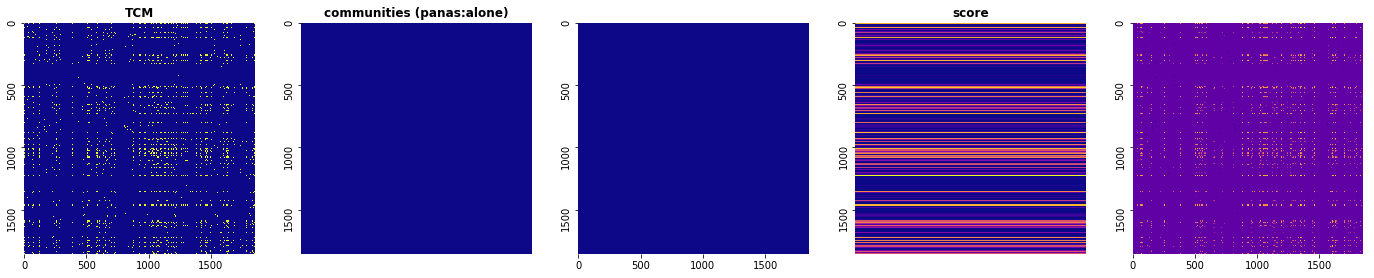

                   scoring: panas:amazed (1856,) score.shape: (1856,) => (1856, 1)


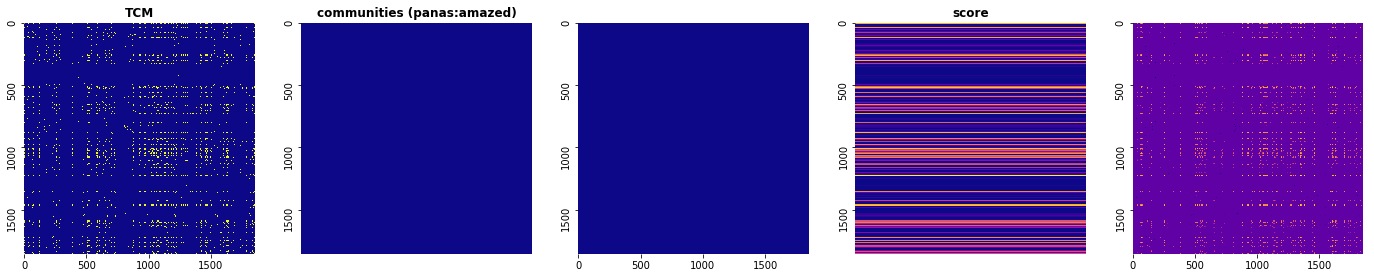

                   scoring: panas:angry (1856,) score.shape: (1856,) => (1856, 1)


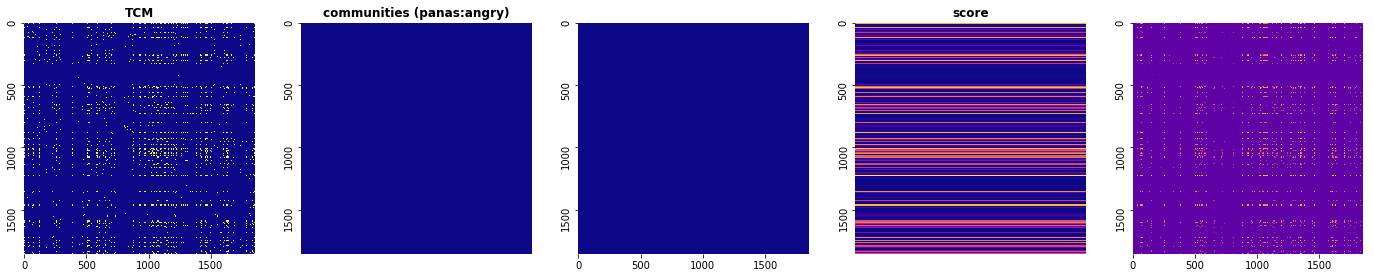

                   scoring: panas:angry_at_self (1856,) score.shape: (1856,) => (1856, 1)


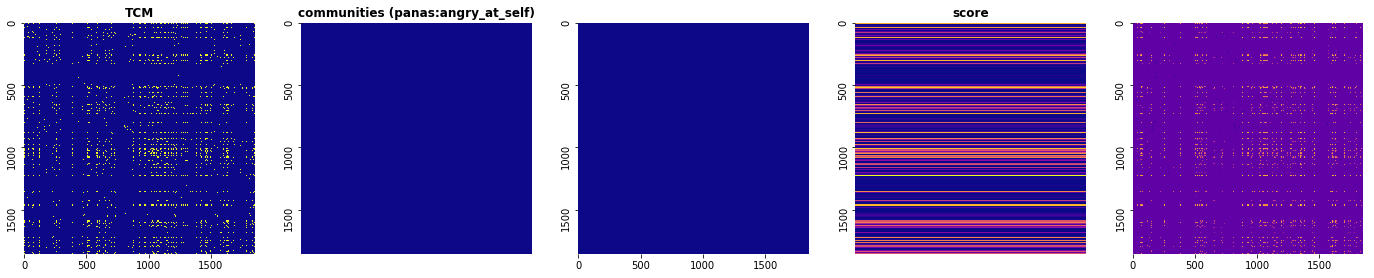

                   scoring: panas:ashamed (1856,) score.shape: (1856,) => (1856, 1)


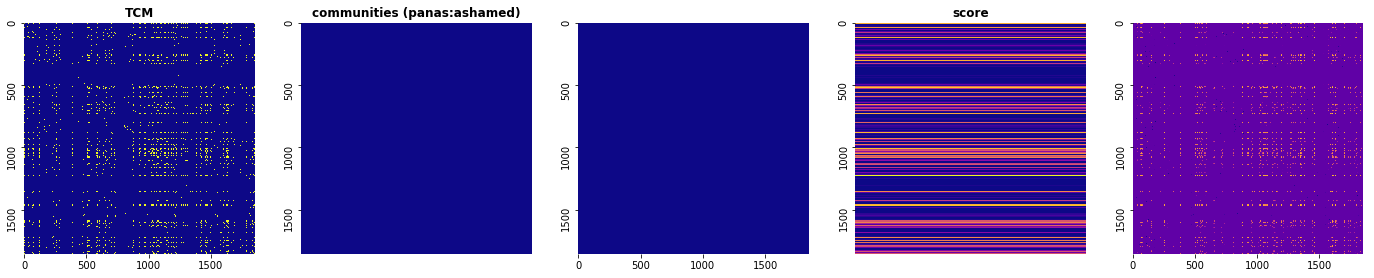

                   scoring: panas:astonished (1856,) score.shape: (1856,) => (1856, 1)


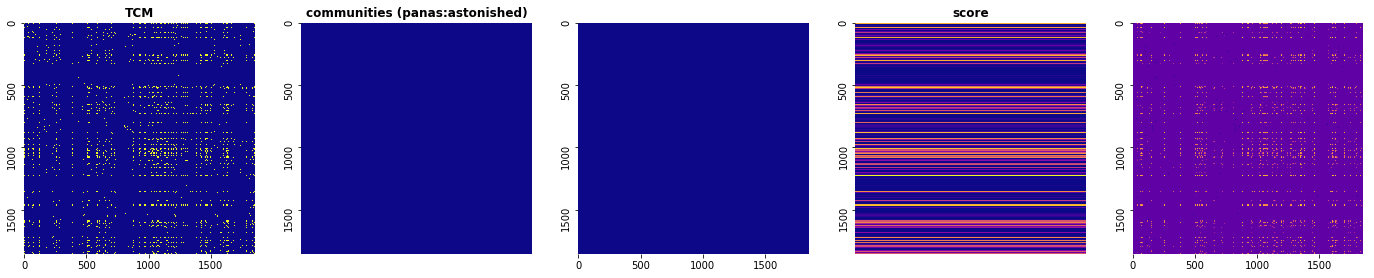

                   scoring: panas:at_ease (1856,) score.shape: (1856,) => (1856, 1)


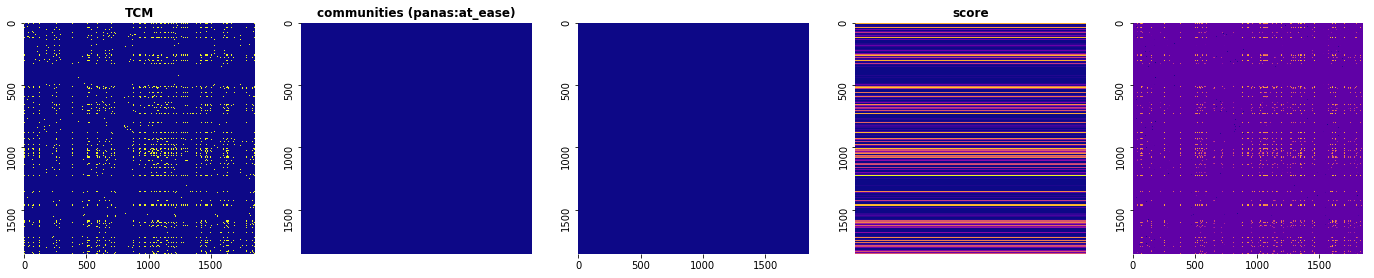

                   scoring: panas:attentive (1856,) score.shape: (1856,) => (1856, 1)


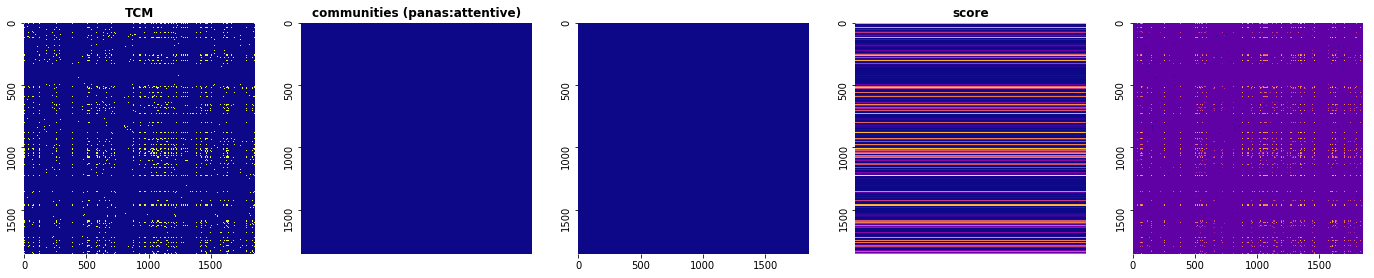

                   scoring: panas:bashful (1856,) score.shape: (1856,) => (1856, 1)


In [ ]:
scores.meta.modz = visualize_metric(W=TCM, c=coloring, metric=bct.module_degree_zscore)

In [ ]:
#scores.meta.pcoef = visualize_metric(W=TCM, c=coloring, metric=bct.participation_coef)

In [ ]:
#scores.meta.pcoef_s = visualize_metric(W=TCM, c=coloring, metric=bct.participation_coef_sign)

#### old

### Run Mapper in anatomical space - create one super graph for both fed and fasted